In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [2]:
# -----------------------------
# 1. Data Loading and Splitting
# -----------------------------
file_path = '/kaggle/input/affectnet-training-data/labels.csv'
data = pd.read_csv(file_path)

# Split the dataset into training (60%), and temporary (40%) datasets
train_dataset, temp_data = train_test_split(data, test_size=0.4, random_state=42)
# Split the temporary dataset into validation (20%) and test (20%)
val_dataset, test_dataset = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Total dataset size: {len(data)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 28175
Training set size: 16905
Validation set size: 5635
Test set size: 5635


In [3]:
# -----------------------------
# 2. Data Generator with Augmentation
# -----------------------------
def create_data_generator(dataframe, directory, batch_size, is_train=False):
    if is_train:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col="pth",
        y_col="label",
        batch_size=batch_size,
        class_mode='categorical',
        target_size=(96, 96),
        shuffle=is_train
    )
    return generator

In [4]:
batch_size = 32

In [5]:
train_generator = create_data_generator(train_dataset, '/kaggle/input/affectnet-training-data/', batch_size, is_train=True)

Found 16905 validated image filenames belonging to 8 classes.


In [6]:
val_generator = create_data_generator(val_dataset, '/kaggle/input/affectnet-training-data/', batch_size)

Found 5635 validated image filenames belonging to 8 classes.


In [7]:
test_generator = create_data_generator(test_dataset, '/kaggle/input/affectnet-training-data/', batch_size)

Found 5635 validated image filenames belonging to 8 classes.


In [ ]:
# -----------------------------
# 3. Model Architecture (Custom Residual Network)
# -----------------------------
def residual_block(x, filters, kernel_size=3, strides=1, dropout_rate=0.0):
    shortcut = x
    # First convolution: Conv -> BN -> LeakyReLU
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    
    if dropout_rate > 0:
        x = layers.SpatialDropout2D(dropout_rate)(x)
    
    # Second convolution: Conv -> BN (no activation)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust shortcut dimensions if needed
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                 kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Combine and activate
    x = layers.add([x, shortcut])
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    return x

def build_novel_emotion_model(input_shape=(96, 96, 3), num_classes=8):
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    x = layers.Conv2D(16, (3, 3), strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    
    # Residual blocks with increasing filters and downsampling
    x = residual_block(x, filters=32, strides=2, dropout_rate=0.1)  # 48x48
    x = residual_block(x, filters=32, strides=1, dropout_rate=0.1)
    
    x = residual_block(x, filters=64, strides=2, dropout_rate=0.1)  # 24x24
    x = residual_block(x, filters=64, strides=1, dropout_rate=0.1)
    
    x = residual_block(x, filters=128, strides=2, dropout_rate=0.2)  # 12x12
    x = residual_block(x, filters=128, strides=1, dropout_rate=0.2)
    
    x = residual_block(x, filters=256, strides=2, dropout_rate=0.2)  # 6x6
    x = residual_block(x, filters=256, strides=1, dropout_rate=0.2)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers with dropout and batch normalization
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

novel_model = build_novel_emotion_model()

In [9]:
novel_model.compile(optimizer=Adam(learning_rate=1e-3),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])

In [10]:
novel_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 96, 16)     │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 96, 96, 16)     │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 96, 96, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 32)     │          4,640 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 48, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 48, 48, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 48, 48, 32)     │              0 │ leaky_re_lu_1[0][0]    │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 48, 32)     │          9,248 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 48, 32)     │            544 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 48, 48, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 48, 48, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48, 48, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 48, 48, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 48, 48, 32)     │          9,248 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 48, 48, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,840,232 (10.83 MB)

 Trainable params: 2,835,016 (10.81 MB)

 Non-trainable params: 5,216 (20.38 KB)

In [11]:
# -----------------------------
# 4. Callbacks for Training
# -----------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('emotion_lens_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [12]:
# -----------------------------
# 5. Train the Model
# -----------------------------
history = novel_model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=callbacks_list)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


528/529 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.1348 - loss: 2.6206 - precision: 0.1408 - recall: 0.0120
Epoch 1: val_loss improved from inf to 2.30095, saving model to emotion_lens_model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 223s 353ms/step - accuracy: 0.1348 - loss: 2.6201 - precision: 0.1409 - recall: 0.0120 - val_accuracy: 0.1551 - val_loss: 2.3009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/200
529/529 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1455 - loss: 2.3366 - precision: 0.0961 - recall: 5.4726e-04
Epoch 2: val_loss improved from 2.30095 to 2.25741, saving model to emotion_lens_model.keras
529/529 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - accuracy: 0.1455 - loss: 2.3365 - precision: 0.0961 - recall: 5.4679e-04 - val_accuracy: 0.1608 - val_loss: 2.2574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/200
528/529 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1551 - loss: 2.2644 - precision:

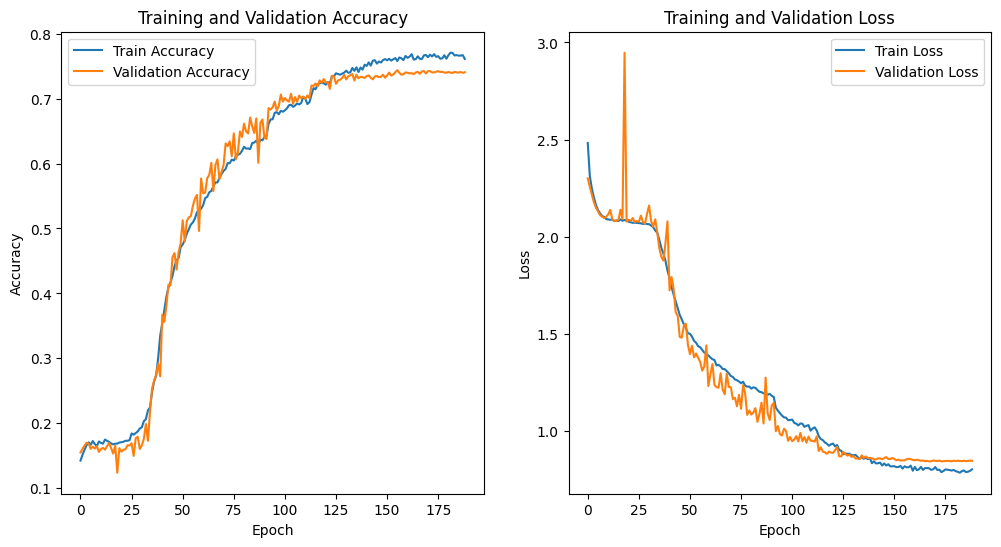

In [13]:
# -----------------------------
# 6. Plot Training History
# -----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_training_history(history)

In [14]:
# -----------------------------
# 7. Evaluate on Test Data
# -----------------------------
test_metrics = novel_model.evaluate(test_generator)
print(f"Test Metrics: {test_metrics}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.7396 - loss: 0.8509 - precision: 0.7787 - recall: 0.6981
Test Metrics: [0.8391748070716858, 0.7444543242454529, 0.784399151802063, 0.7031055688858032]


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step
Weighted F1 Score: 0.7425911231567396


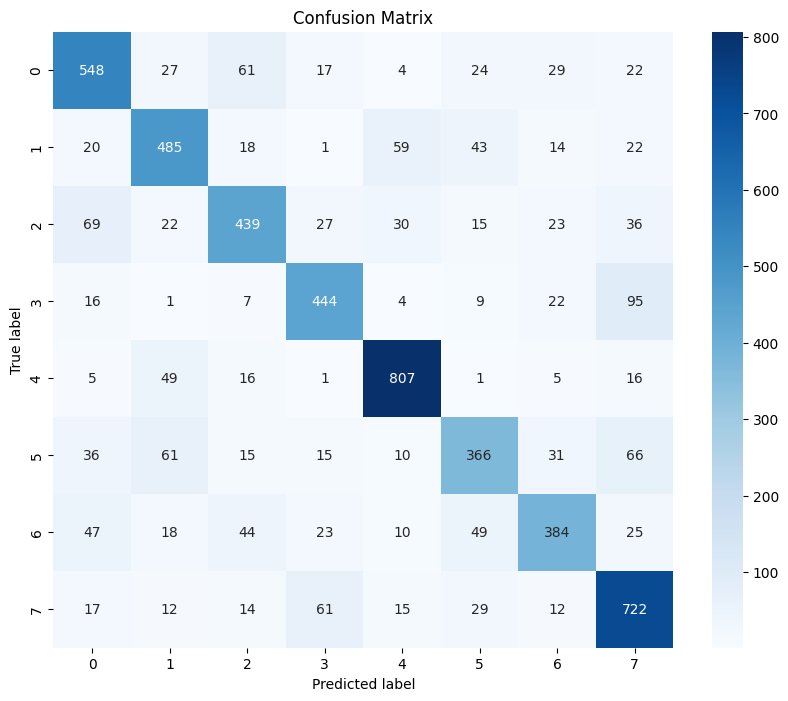

Multiclass ROC AUC Score: 0.9642961733433284


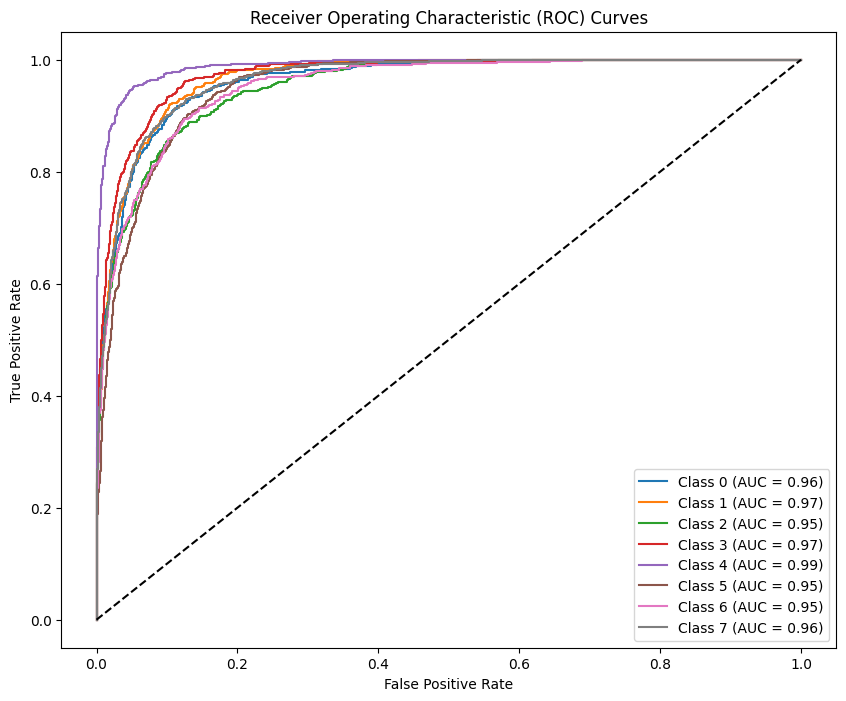

In [15]:
# -----------------------------
# 8. Additional Metrics: F1 Score, AUC ROC, and Confusion Matrix
# -----------------------------
# Get true labels and predictions
test_steps = test_generator.samples // test_generator.batch_size + 1
y_pred_proba = novel_model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

# Calculate Weighted F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Multiclass ROC AUC Score and ROC Curves
num_classes = 8
y_true_onehot = label_binarize(y_true, classes=list(range(num_classes)))

try:
    auc_roc = roc_auc_score(y_true_onehot, y_pred_proba, multi_class='ovr')
    print(f"Multiclass ROC AUC Score: {auc_roc}")
except Exception as e:
    print("Error computing ROC AUC:", e)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()